# Proyecto
## Tienda online **`ice`**
#### Descripción del proyecto

Trabajas para la tienda online **Ice** que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. Tienes que **identificar patrones** que determinen si un juego tiene éxito o no. Esto te permitirá detectar proyectos prometedores y planificar campañas publicitarias.

Delante de ti hay **datos que se remontan a 2016**. Imaginemos que es diciembre de 2016 y estás planeando una campaña para 2017.

Lo importante es adquirir experiencia de trabajo con datos. Realmente no importa si estás pronosticando las ventas de 2017 en función de los datos de 2016 o las ventas de 2027 en función de los datos de 2026.

El dataset contiene una columna "`rating`" que almacena la clasificación ESRB de cada juego. El Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento) evalúa el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto.

### Paso 1. Abrir archivo y estudiar información general

In [1]:
# Primero voy a importar las librerías
from scipy import stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importar información
df_games = pd.read_csv('datasets/games.csv')

In [3]:
df_games.info()

df_games.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


De cajón se puede observar que hay 2 juegos con nombres ausentes. Lo veré más adelante en la preparación de datos.

Con respecto a *plataforma, género y ventas de todas las regiones* **no hay valores nulos**, lo cual es un alivio.

El año de lanzamiento es flotante, lo cual se tiene que cambiar por obvias razones.

Los puntajes no son consistentes, algunos son de 0 a 100 y el otro de 0 a 10. Esto se tiene que arreglar. Además de que tienen bastantes valores ausentes.

El rating también tiene valores ausentes lo cual puede ser un problema. También se tiene que resolver.

### Paso 2. Preparar los datos

#### Funciones
Voy a escribir unas funciones para optimizar un poco el código

In [4]:
# Función para retornar una proporción, redondeado a 2 dígitos
def calcularProporcion(faltante, total):
    return round(faltante / total * 100, 2)

#### Nombres de las columnas

In [5]:
# Reemplazar los nombres de las columnas
df_games.columns = df_games.columns.str.lower()

#### Valores ausentes
##### Columna nombres

In [6]:
# Valores ausentes en nombres
print(f"Cantidad de nombres faltantes: {df_games['name'].isna().sum()}")

Cantidad de nombres faltantes: 2


Solamente hay 2 registros con nombre nulo, por lo que no nos tenemos que preocupar por esto.

In [7]:
# Borrar estos registros con valores nulos, ya que son irrelevantes
df_games = df_games[~df_games['name'].isna()]

##### Columna del año de lanzamiento

In [8]:
# Contar el total de juegos
total_games_count = len(df_games)

# Calcular la cantidad de registros con año de lanzamiento nulo
años_faltantes = df_games['year_of_release'].isna().sum()

# Proporción de faltantes
prop_años = calcularProporcion(años_faltantes, total_games_count)
print(f"Proporcion de columnas de año de lanzamiento con valores nulos: %{prop_años}")

Proporcion de columnas de año de lanzamiento con valores nulos: %1.61


El %1.61 de registros no tienen el año de lanzamiento, no es una proporcion significativa, vamos a eliminarlos porque no representaría una alteración significativa para nuestros cálculos.

In [9]:
# Borrar estos registros con valores nulos, ya que son irrelevantes
df_games = df_games[~df_games['year_of_release'].isna()]

##### Columna de crítica

In [10]:
# Calcular cantidad de registros con calificaciones nulas
cal_crit_faltante = df_games['critic_score'].isna().sum()

# Calcular proporciones
prop_crit = calcularProporcion(cal_crit_faltante, total_games_count)

print(f"Proporcion de columnas de calificación de la crítica con valores nulos: %{prop_crit}")

Proporcion de columnas de calificación de la crítica con valores nulos: %50.63


Podemos ver que hay un porcentaje significativamente alto en proporción a la cantidad de registros con valores nulos, sería muy costoso para nuestros calculos, por esto no los podemos ignorar. Voy a reemplazar los valores nulos con promedios.

In [11]:
# Rellena los valores nulos con las calificaciones promedio dependiendo del género del juego
df_games['critic_score'] = df_games.groupby('genre')['critic_score'].transform(
    lambda x: x.fillna(x.mean())
)

##### Columna de calificaciones de usuarios

In [12]:
# Calcular cantidad de registros con calificaciones nulas
cal_user_faltante = df_games['user_score'].isna().sum()

# Calcular proporciones
prop_user = calcularProporcion(cal_user_faltante, total_games_count)

print(f"Proporcion de columnas de calificación de usuarios con valores nulos: %{prop_user}")

Proporcion de columnas de calificación de usuarios con valores nulos: %39.52


Aquí también tenemos un porcentaje significativo de valores nulos, pero no solo eso, también tenemos muchos valores con 'tbd'.

In [13]:
# Registros con 'tbd'
count_tbd = (df_games['user_score'] == 'tbd').sum()

# Calcular proporcion con valores 'tbd'
prop_tbd = calcularProporcion(count_tbd, total_games_count)

print(f"Proporcion de registros con 'tbd': %{prop_tbd}")

Proporcion de registros con 'tbd': %14.22


Tenemos más de un %50 de registros con valores que NO son calificaciones.

No creo que pueda asignar algún valor a estos registros porque podría dar pie a sesgos en los cálculos. Voy a optar por **hacer que los 'tbd' sean valores nulos**, y voy a usar esta columna como variable secundaria, sólo lo voy a usar para análisis donde esté disponible.

Siendo que hay demasiados registros con esta columna nula, no puedo simplemente eliminar esos registros, pero tampoco voy a usar esta columna para cosas tan relevantes por el hecho de que más de la mitad de esta columna es inútil.

In [14]:
# Cambiar 'tbd' a nulos
df_games['user_score'] = df_games['user_score'].replace('tbd', np.nan)

##### Columna de rating

In [15]:
# Calcular cantidad de registros con rating nulos
rating_faltante = df_games['rating'].isna().sum()

# Calcular proporciones
prop_rating = calcularProporcion(rating_faltante, total_games_count)

print(f"Proporcion de columnas de rating con valores nulos: %{prop_rating}")

Proporcion de columnas de rating con valores nulos: %39.94


Hay un porcentaje significativo de juegos sin rating, no se pueden simplemente ignorar.

Analizando los datos más a fondo veo que no hay algún patrón claro para poder hacer calificaciones intuitivas, por ejemplo, podría asumir que los Shooter automáticamente los puedo marcar con rating M, pero hay juegos que son Shooter calificados como E10+ y T, así que no se puede rellenar intuitivamente esta columna, por lo que voy a dejar estos juegos con rating `unrated`, ya que es transparente para análisis posteriores.

In [16]:
df_games['rating'] = df_games['rating'].fillna('Unrated')

##### ¿Por qué hay valores nulos?

Con respecto al `year_of_release` puede que los valores nulos se deban a que pueden haber juegos muy antiguos sin registro exacto de lanzamientos, por ports/remasters que tienen fechas ambiguas resultado de la reutilización de código base en versiones anteriores.

Con `critic_score` puede tener valores nulos debido a la cobertura de las organizaciones de crítica, tal vez no cubren juegos indies. Tal vez depende del lanzamiento regional, tal vez hay títulos lanzados en japón o europa y no hay registros de medios globales que califiquen los juegos, o por lo menos no según la información extraída para este análisis.

En `user_score` puede tener una mezcla de factores como la columna anterior, o puede haber diferentes factores como la anitüedad de los juegos, en los juegos más antiguos es donde más se ven valores nulos. Con respecto a 'tbd', teniendo en cuenta que los valores son de 2016 y los estamos usando para hacer estimaciones para 2017 **podríamos** especular que al momento de extracción de la información se encuentra desactualizada la información debido a que es muy reciente, PERO analizando más a fondo los registros con 'tbd' puedo ver que hay cientos de juegos con bastante antigüedad, algunos teniendo ya 5 años de antiguedad a la extracción de los datos. Aquí solamente me resta especular que hay una falta de dedicación por parte de las organizaciones correspondientes para recopilar las calificaciones de los usuarios, o de a plano hay incompetencia para determinar el mismo.

Y con `rating` puede haber valores nulos debido a que hay juegos en las que no calsifica el rating ESRB, ya sea porque son bundles o por alguna otra razón específica como ediciones especiales con versión física limitadas sin proceso formal de rating. Pero dado que hay una cantidad significativa de valores nulos en esta columna, es difícil especular.

En general algunos de los valores nulos correspondientes a calificaciones se puede deber al tipo de cobertura que tenga el juego, sea por la region donde fue vendida, tanto como la categoría del juego, por ejemplo cuando un juego se vende como bundle o paquete de 2 o más juegos en una venta.

Como sea, a algunos de los valore nulos se podría atribuir a error de captura o extracción de información sea por cuestiones técnicas o por recolección de múltiples fuentes, pero eso es difícil de determinar.

#### Conversión de datos a los correspondientes

In [17]:
# year_of_release float -> int
df_games['year_of_release'] = df_games['year_of_release'].astype(int)

# critic_score float -> int
df_games['critic_score'] = np.round(df_games['critic_score']).astype('Int64')

# user_score primero convertir object -> float, multiplicar por 10 y entonces float -> int
user_score_float = pd.to_numeric(df_games['user_score'])
df_games['user_score'] = (user_score_float * 10).astype('Int64')

In [18]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  Int64  
 9   user_score       7463 non-null   Int64  
 10  rating           16444 non-null  object 
dtypes: Int64(2), float64(4), int64(1), object(4)
memory usage: 1.5+ MB


Estos tipos de datos los convertí así por las siguientes razones:
- `year_of_release` no necesita explicación, no tiene sentido que sea float.
- `critic_score` lo cambié a entero siendo que no es necesario el uso de decimales siendo que es una escala de 0 a 100, además de que ningún registro tiene decimales en esta columna.
- `user_score` lo cambié a enteros igual, pero como era una escala de 0 a 10 con decimales, lo multipliqué por 10 por 2 razones; al hacerlo escala de 0 a 100 ya se puede convertir a entero sin perder calificaciones (ya que de todas formas seguía una escala de calificación igual de 0 a 100, pero con decimales), y también esto nos va a servir para poder hacer cálculos y comparaciones con la columna 'critic_score', ya que al finales tienen propósitos afines.

**¿Por qué no cambié el formato de ventas?**

No vi necesario hacer ningún tipo de movimientos a esos ya que tenemos a nuestra disposición que esos números "pequeños" son representaciones de millones de su valor. Además no veo ningún problema con los números que ya hay, no veo inconsistencias ni valores nulos.

In [19]:
# Calcular ventas totales con todas las regiones
df_games['global_sales'] = np.round(df_games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1), 2)

df_games[['name', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales']].head(10)

,name,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,Wii Sports,41.36,28.96,3.77,8.45,82.54
1,Super Mario Bros.,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,15.68,12.76,3.79,3.29,35.52
3,Wii Sports Resort,15.61,10.93,3.28,2.95,32.77
4,Pokemon Red/Pokemon Blue,11.27,8.89,10.22,1.00,31.38
5,Tetris,23.20,2.26,4.22,0.58,30.26
6,New Super Mario Bros.,11.28,9.14,6.50,2.88,29.80
7,Wii Play,13.96,9.18,2.93,2.84,28.91
8,New Super Mario Bros. Wii,14.44,6.94,4.70,2.24,28.32
9,Duck Hunt,26.93,0.63,0.28,0.47,28.31


### Paso 3. Analizar datos

**Mira cuántos juegos fueron lanzados en diferentes años. ¿Son significativos los datos de cada período?**

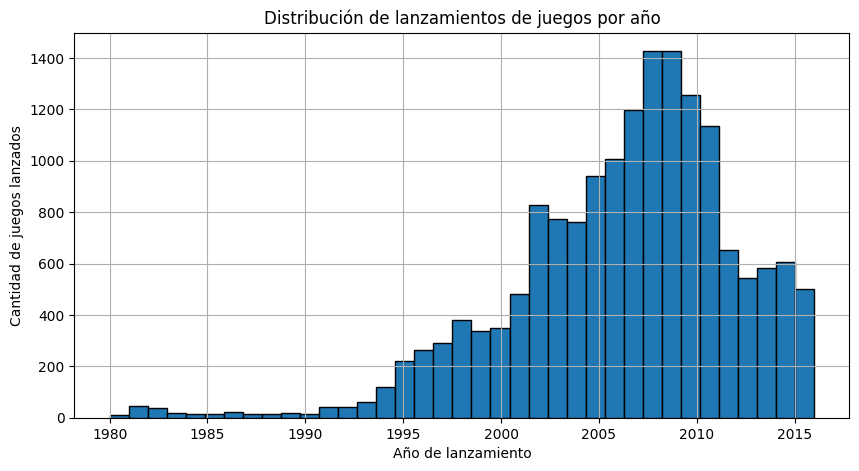

In [20]:
#df_games['year_of_release'].value_counts().sort_index()

df_games['year_of_release'].plot(
    kind='hist',
    bins=37,
    edgecolor='black',
    figsize=(10, 5),
    title='Distribución de lanzamientos de juegos por año'
)
plt.xlabel('Año de lanzamiento')
plt.ylabel('Cantidad de juegos lanzados')
plt.grid(True)
plt.show()

Se puede ver que en la década de los 80's casi es insignificativo la cantidad de lanzamientos que hay enc omparación al resto del histograma.

Empieza a empezar el auge de los videojuegos en la década de los 90's, subiendo gradualmente teniendo un pico entre 2005 y 2010, en concreto parece tener pico en 2008, superando los 1400 lanzamientos por año.

Hay una caída de lanzamientos después de 2010, manteniendose relativamente estable alrededor de 600 lanzamientos por año.

**Observa cómo varían las ventas de una plataforma a otra. Elige las plataformas con las mayores ventas totales y construye una distribución basada en los datos de cada año. Busca las plataformas que solían ser populares pero que ahora no tienen ventas. ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?**

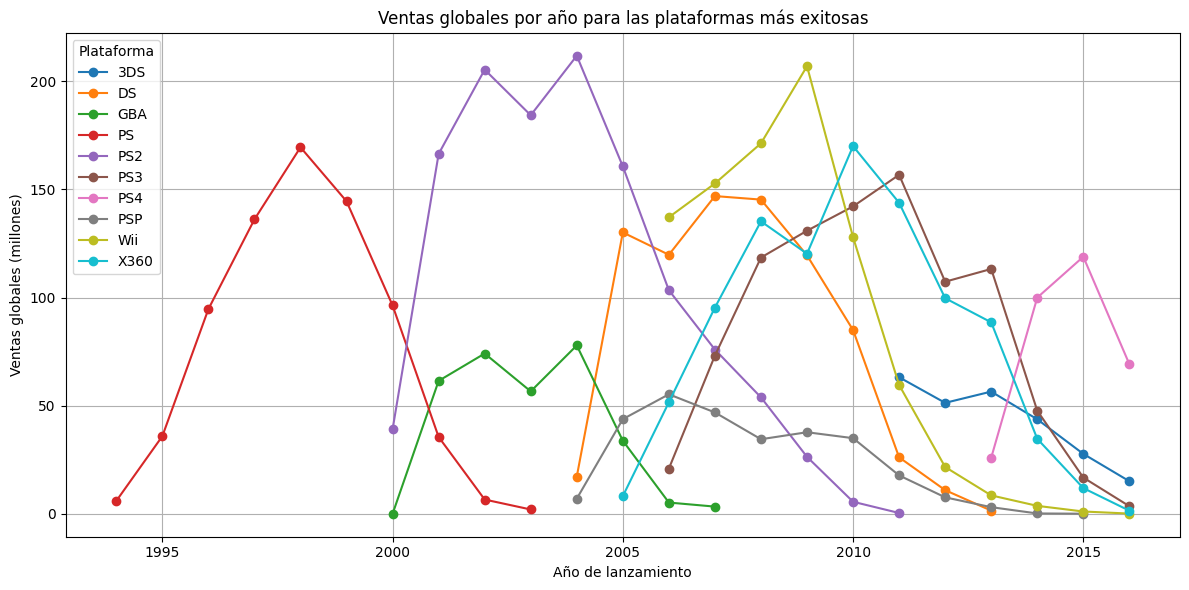

In [ ]:
# Ver ventas totales por plataforma en orden
global_platform_sales = df_games.groupby('platform')['global_sales'].sum().sort_values(ascending=False)

# Sleccionar las mejores plataformas
top_platforms = global_platform_sales.head(10).index.tolist()

# Filtrar el df
sales_filtered_df = df_games[df_games['platform'].isin(top_platforms)]

# Agrupar por año y plataforma
yearly_sales = sales_filtered_df.groupby(['year_of_release', 'platform'])['global_sales'].sum().unstack().loc[1990:2016]

# Graficar
yearly_sales.plot(
    kind="line",
    marker="o",
    figsize=(12, 6),
    title="Ventas globales por año para las plataformas más exitosas"
)
plt.xlabel("Año de lanzamiento")
plt.ylabel("Ventas globales (millones)")
plt.grid(True)
plt.legend(title="Plataforma")
plt.tight_layout()
plt.show()

En la gráfica se pueden aprecias las ventas de las mejores 10 consolas que tenemos registros.

Prestando atención podemos darnos cuenta de que las ventas de las consolas solían mantenerse más en épocas anteriores, por tomar un ejemplo en concreto podemos mencionar el caso de la Playstation, Su primera tiene buenas ventas, acorde a lo revolucionario que fue en su moemnto, la PS2 tiene las mejores ventas, acorde a su mérito de ser la consola con más ventas en la historia, pero podemos ver como las ventas van cayendo con PS3 y la PS4.

No podemos decir lo mismo con las ventas de las consolas de Nintendo, ya que las ventas del GBA son algo decentes, pero no a comparación de su siguiente entrega; la DS, siendo que esta consola revolucionó la industria, hace sentido el pico de ventas que tiene esta consola en comparación a su predecesor.

Con respecto a cuánto tiempo se mantienen, podemos ver cómo los juegos de antes mantenían bastante retención con extensos años de desarrollo en cada respectiva consola, aunque pueda tener ventas bajas a comparación del resto (como se ve en la gráfica, el PSP) se mantiene las ventas por bastantes años. Pero no podemos decir lo mismo de la PS4, que es la única consola que tenemos con mejores ventas que su uso de vida ha sido considerablemente corto en comparación con el resto de consolas.

**Determina para qué período debes tomar datos. Para hacerlo mira tus respuestas a las preguntas anteriores. Los datos deberían permitirte construir un modelo para 2017.**

Viendo la información y las gráficas voy a determinar el uso de los juegos lanzados desde 2001 hasta 2016, siendo que a partir de 2001 ya hay muchos juegos con dioversidad de plataformas y géneros, además de que en 2001 ya hay una considerable actividad de ventas en comparación a años pasados.

Además, incluir estos años nos es más cerca la época de estos videojuegos, hacer predicciones con juegos de décadas más pasadas podría darnos información desactualizada u obsoleta que potencialmente ya no aplican para épocas actuales.

**Trabaja solo con los datos que consideras relevantes. Ignora los datos de años anteriores.**

In [22]:
# Conservar la información de 2001 a 2016
df_games = df_games[df_games['year_of_release'].between(2001, 2016)]

**¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Elige varias plataformas potencialmente rentables.**

In [23]:
# Mostrar las plataformas líderes en ventas
df_games.groupby('platform')['global_sales'].sum().sort_values(ascending=False).head(10)

platform
PS2     1194.39
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS4      314.14
GBA      312.81
PSP      289.53
3DS      257.81
XB       250.58
Name: global_sales, dtype: float64

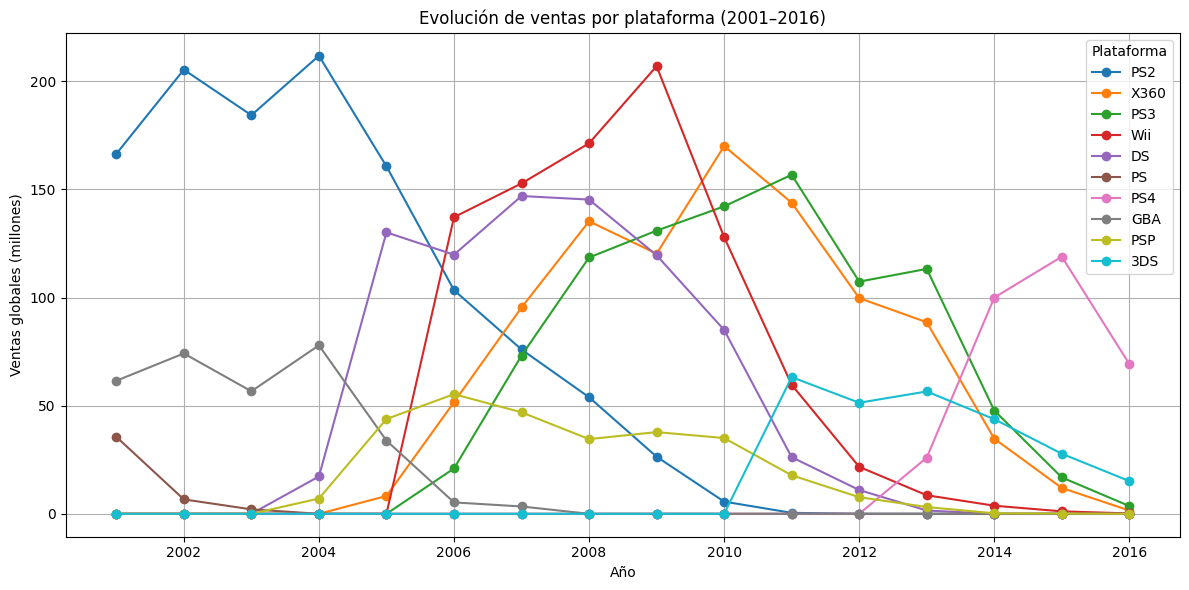

In [ ]:
# Ventas globales por año y plataforma
yearly_platform_sales = (
    df_games.groupby(['year_of_release', 'platform'])['global_sales']
    .sum()
    .unstack(fill_value=0)
)

# Visualizar como gráfico de líneas para las top 10 plataformas
top_platforms = global_platform_sales.head(10).index.tolist()

# Graficar
yearly_platform_sales[top_platforms].plot(
    kind="line", marker="o", figsize=(12, 6), title="Evolución de ventas por plataforma (2001–2016)")
plt.xlabel("Año")
plt.ylabel("Ventas globales (millones)")
plt.grid(True)
plt.legend(title="Plataforma")
plt.tight_layout()
plt.show()

Podemos apreciar cómo las plataformas más exitosas se han mantenido en las últimas décadas, pero estos no nos dice mucho sobre cómo les ha ido últimamente. Al contrario, nos demuestra como la mayoría de las plataformas más exitosas ya llegaron o están a punto de llegar a sus últimos años de vida.

Así que voy a hacer un cálculo de las mejores ventas en estos últimos 2 años; 2015 y 2016. Puede que no tengan mucha información, pero eso es esperado de consolas que han tenido poca vida.

In [25]:
recent_sales = (
    df_games[df_games['year_of_release'] >= 2015]
    .groupby('platform')['global_sales']
    .sum()
    .sort_values(ascending=False)
)

print('Plataformas más activas en 2015-2016')
print(recent_sales)

Plataformas más activas en 2015-2016
platform
PS4     188.15
XOne     86.29
3DS      42.92
WiiU     20.95
PS3      20.42
PC       13.77
X360     13.48
PSV      10.50
Wii       1.32
PSP       0.12
Name: global_sales, dtype: float64


Se puede apreciar un contraste diferente, ya que ahora en las mejores ventas estos últimos par de años no vemos a las plataformas más exitosas históricamente, sino que vemos a las plataformas que siguen en auge.

Como ejemplo podemos ver a los top 3, que son el PS4, Xbox One y Nintendo 3DS; los primeros dos siendo las consolas principales que empezaron la "guerra" de la nueva generación de videojuegos. Seguido podemos ver a la Wii U que sabemos históricamente que terminó siendo un fracaso, y la PS3 que todavía tiene ventas, pero con la gráfica y el contraste con PS4 podemos deducir que llegados a estos dos últimos años, esta plataforma ya está en las últimas.

**Crea un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma. ¿Son significativas las diferencias en las ventas? ¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos.**

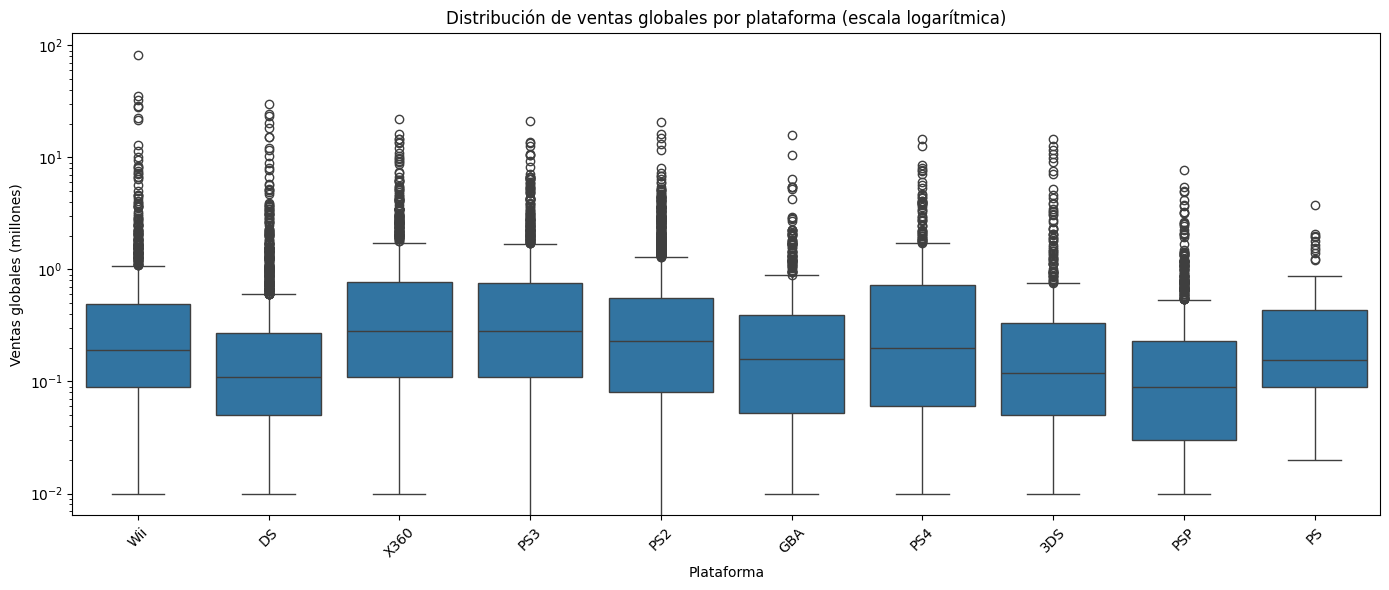

In [26]:
# Filtrar plataformas
df_box = df_games[df_games['platform'].isin(top_platforms)]

# Crear boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_box, x='platform', y='global_sales')
plt.yscale('log')
plt.title('Distribución de ventas globales por plataforma (escala logarítmica)')
plt.xlabel('Plataforma')
plt.ylabel('Ventas globales (millones)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Opté por escala logarítmica debido a la diferencia de ventas que hay, las cajas se verían muy delgadas si no fuera así.

Con respecto a las cajas, podemos obesrvar cosas interesantes, primero es que todas las cajas tienen **outliers** hacia arriba, lo que indica que unos pocos juegos venden muchísimo, mientras que la mayoría venden poco.

La mayoría de las plataformas tienen una mediana de vetnas globales entre 0.1 y 0.3 millones, lo que significa que para la mayoría de los juegos, las ventas no fueron especialmente altas, lo cual es natural dada la cantidad de juegos que se desarrollan.

Puedo observar que las plataformas con mayores medianas o cajas más altas son la Wii, Xbox 360, PS3 y PS4, ya que las cajas (Q1-Q3) son las que más o menos están más desplazadas hacia arriba, y siendo escala logarítmica, puede ser significativo, lo que sugiere un mayor volumen de juegos con ventas decentes; en especial Xbox 360 y PS3 que muestran buenas distribuciones con medianas más altas y menos disperción negativa. También podría contar PS2, pero el hecho de que su disperción negativa supere la gráfica le resta puntos.

Como observación, PS2 y DS tienen una base muy grande de juegos, pero la mayoría no vendió tanto. Solo unos pocos títulos tuvieron ventas muy altas (los outliers); esto sugiere una alta saturación, o muchos lanzamientos de juegos poco exitosos.

Y las plataformas con menor rendimiento típico serían PSP y DS, ya que tienen las medianas más bajas.

In [27]:
# Ventas promedio por plataforma (millones)
mean_sales = df_box.groupby('platform')['global_sales'].mean().sort_values(ascending=False)
print(mean_sales)

platform
PS4     0.801378
X360    0.780227
PS3     0.713124
Wii     0.692986
PS2     0.584054
3DS     0.503535
PS      0.388860
GBA     0.386185
DS      0.378660
PSP     0.242691
Name: global_sales, dtype: float64


Con las ventas promedio podemos comprobar justo lo platicado con las cajas, estando Xbox 360, PS3 y la Wii en las mejores, siendo superados por PS4, esto puede ser explicado dado a que PS4 tiene menos años de vida que los otros, siendo favorable en su promedio y dando a notar su éxito en su poco tiempo de vida.

**Mira cómo las reseñas de usuarios y profesionales afectan las ventas de una plataforma popular (tu elección). Crea un gráfico de dispersión y calcula la correlación entre las reseñas y las ventas. Saca conclusiones.**

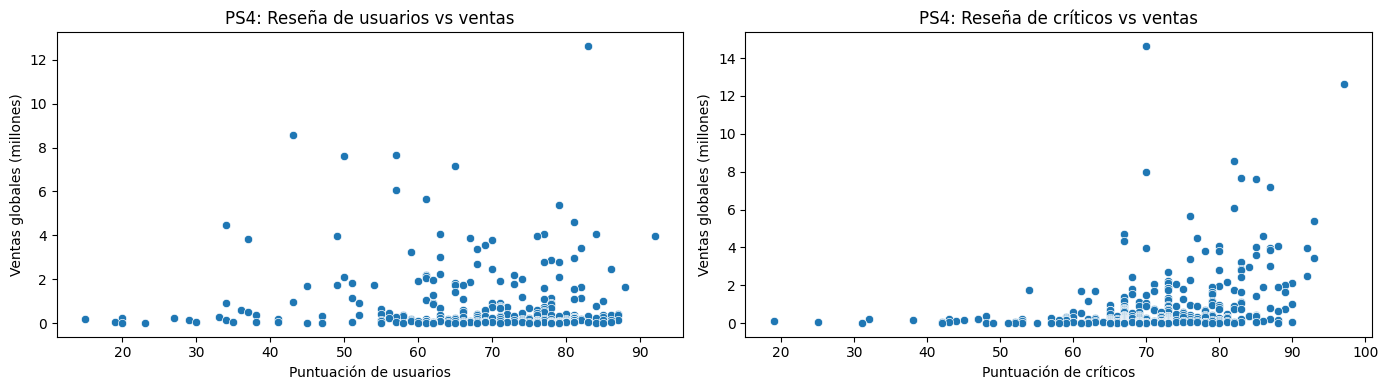

Correlación entre 'user_score' y 'global_sales' para PS4: -0.032
Correlación entre 'critic_score' y 'global_sales' para PS4: 0.352


In [28]:
# Filtrar solo los juegos de PS4
ps4_data = df_games[df_games['platform'] == 'PS4']

# Convertir user_score a numérico
ps4_data.loc[:, 'user_score'] = pd.to_numeric(ps4_data['user_score'], errors='coerce')

# Gráfico de dispersión
plt.figure(figsize=(14, 4))

# Reseñas de usuarios vs ventas
plt.subplot(1, 2, 1)
sns.scatterplot(data=ps4_data, x='user_score', y='global_sales')
plt.title('PS4: Reseña de usuarios vs ventas')
plt.xlabel('Puntuación de usuarios')
plt.ylabel('Ventas globales (millones)')

# Reseñas de críticos vs ventas
plt.subplot(1, 2, 2)
sns.scatterplot(data=ps4_data, x='critic_score', y='global_sales')
plt.title('PS4: Reseña de críticos vs ventas')
plt.xlabel('Puntuación de críticos')
plt.ylabel('Ventas globales (millones)')

plt.tight_layout()
plt.show()

# Calcular correlaciones
cor_user = ps4_data['user_score'].corr(ps4_data['global_sales'])
cor_critic = ps4_data['critic_score'].corr(ps4_data['global_sales'])

print(f"Correlación entre 'user_score' y 'global_sales' para PS4: {cor_user:.3f}")
print(f"Correlación entre 'critic_score' y 'global_sales' para PS4: {cor_critic:.3f}")

La correlación con la crítica es **moderadamente positiva**. Cuando las reseñas de críticos son mejores, las ventas tienden a ser mayores. No es una relación muy fuerte, pero es clara.

Y la correlación con los usuarios es **casi nula y negativa**. Las calificaciones de usuarios no parecen tener relación significativa con las ventas.

**Teniendo en cuenta tus conclusiones compara las ventas de los mismos juegos en otras plataformas.**

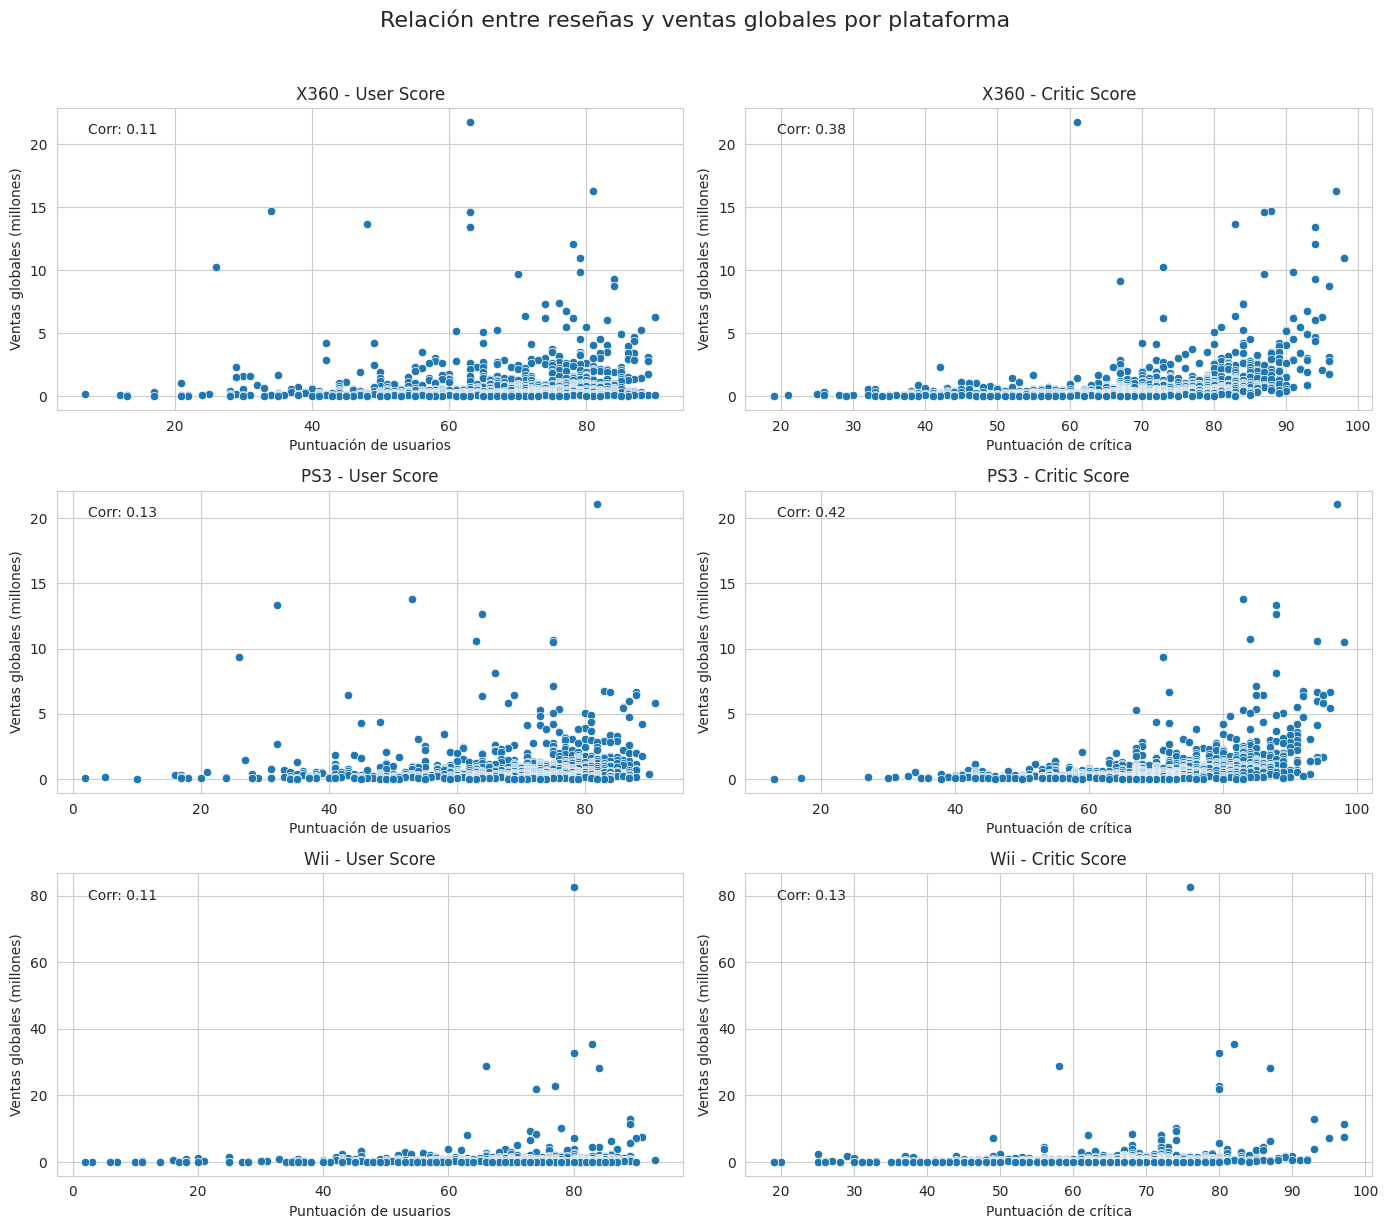

In [29]:
# Plataformas seleccionadas
platforms = ['X360', 'PS3', 'Wii']

# Estilo
sns.set_style(style="whitegrid")
fig, axes = plt.subplots(len(platforms), 2, figsize=(14, 12))
fig.suptitle('Relación entre reseñas y ventas globales por plataforma', fontsize=16, y=1.02)

# Iteramos por plataforma y eje
for i, platform in enumerate(platforms):
    # Filtrar juegos de la plataforma
    df_platform = df_games[df_games['platform'] == platform]
    
    # Gráfico: user_score vs global_sales
    sns.scatterplot(
        ax=axes[i, 0],
        data=df_platform,
        x='user_score',
        y='global_sales',
    )
    axes[i, 0].set_title(f'{platform} - User Score')
    axes[i, 0].set_xlabel('Puntuación de usuarios')
    axes[i, 0].set_ylabel('Ventas globales (millones)')
    
    # Correlación (user_score y ventas)
    corr_user = df_platform[['user_score', 'global_sales']].corr().iloc[0, 1]
    axes[i, 0].text(0.05, 0.95, f'Corr: {corr_user:.2f}', transform=axes[i, 0].transAxes, 
                   fontsize=10, verticalalignment='top')

    # Gráfico: critic_score vs global_sales
    sns.scatterplot(
        ax=axes[i, 1],
        data=df_platform,
        x='critic_score',
        y='global_sales'
    )
    axes[i, 1].set_title(f'{platform} - Critic Score')
    axes[i, 1].set_xlabel('Puntuación de crítica')
    axes[i, 1].set_ylabel('Ventas globales (millones)')
    
    # Correlación (critic_score y ventas)
    corr_critic = df_platform[['critic_score', 'global_sales']].corr().iloc[0, 1]
    axes[i, 1].text(0.05, 0.95, f'Corr: {corr_critic:.2f}', transform=axes[i, 1].transAxes, 
                   fontsize=10, verticalalignment='top')

# Ajuste de diseño
plt.tight_layout()
plt.show()

Con estas plataformas podemos ver un poco de lo mismo, las correlaciones son bastante similares con respecto a las del PS4. La Wii siendo un poco la excepción, no es muy pronunciado la diferencia de las correlaciones, pero es notable.

Como ya concluimos en los gráficos de cajas, hay una gran concentración de juegos con pocas ventas, lo cual podemos ver en general con todas las relaciones. Aunque podemos destacar que tanto para la crítica como para los usuarios, sus calificaciones afectan a algunas exepciones.

Además podemos destacar que los juegos exitosos tienen mejor calificacion por parte de los usuarios, la diferencia es ligera pero notable.

**Echa un vistazo a la distribución general de los juegos por género. ¿Qué se puede decir de los géneros más rentables? ¿Puedes generalizar acerca de los géneros con ventas altas y bajas?**

In [30]:
# Agrupación: total y promedio de ventas por género
genre_stats = df_games.groupby('genre').agg(
    total_sales=('global_sales', 'sum'),
    average_sales=('global_sales', 'mean'),
    count=('name', 'count')
).sort_values(by='total_sales', ascending=False)

# Mostrar la tabla resumida
print(genre_stats)

              total_sales  average_sales  count
genre                                          
Action            1492.18       0.491657   3035
Sports            1089.68       0.574120   1898
Shooter            905.87       0.816835   1109
Misc               702.80       0.445656   1577
Role-Playing       702.17       0.552455   1271
Racing             541.06       0.545423    992
Platform           478.37       0.687313    696
Simulation         332.04       0.440956    753
Fighting           291.64       0.477316    611
Adventure          180.78       0.153463   1178
Puzzle             134.37       0.287730    467
Strategy           106.53       0.199869    533


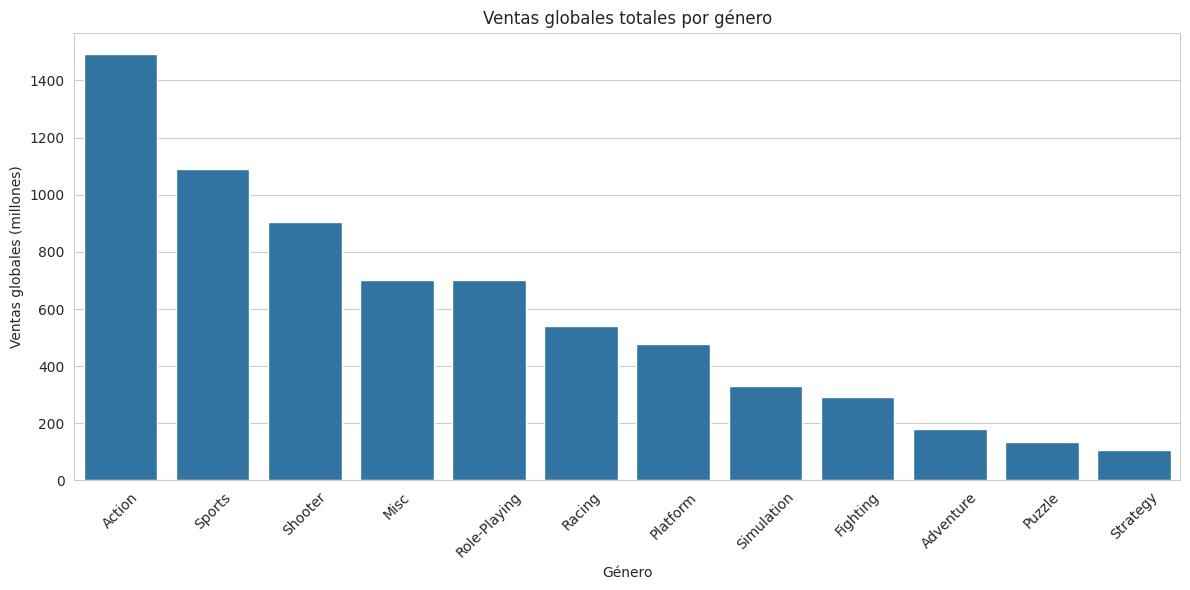

In [31]:
# Gráfico de barras: Ventas totales por género
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_stats.index, y=genre_stats['total_sales'])
plt.title('Ventas globales totales por género')
plt.xlabel('Género')
plt.ylabel('Ventas globales (millones)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Podemos ver que en general los géneros que más han vendido, **acorde a las ventas totales**, son los de **acción**, **deportes** y los **shooters** respectivamente.

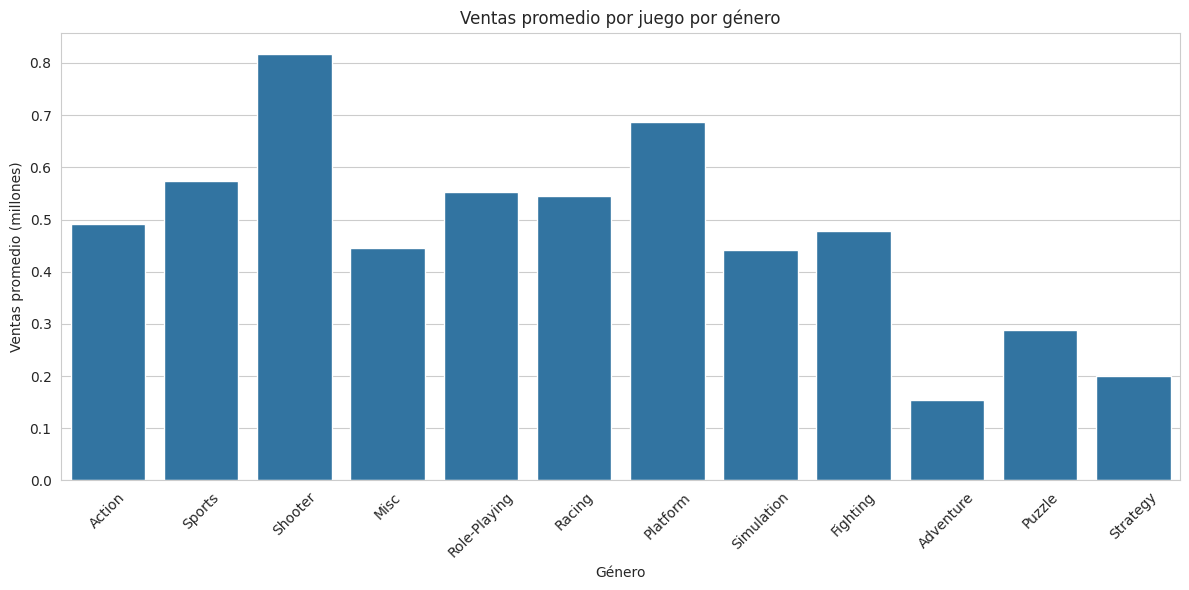

In [32]:
# Gráfico de barras: Ventas promedio por juego
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_stats.index, y=genre_stats['average_sales'])
plt.title('Ventas promedio por juego por género')
plt.xlabel('Género')
plt.ylabel('Ventas promedio (millones)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Lo mismo no se refleja con las ventas promedio.

Podemos apreciar que, **acorde al promedio**, los juegos shooter y los de plataformas son los que más venden.

Entonces como recomendación final según las estadísticas presentadas, mi determinación final es la siguiente:

- **Usar los periodos de 2001 a 2016 para predicciones para los géneros de juegos**

El razonamiento detrás de esto es porque tomando una muestra extensa de juegos sobre los géneros nos dará una idea de las predicciones futuras, ya que los gustos por género de juegos son bastante consistentes a lo largo de los años. Con seguridad puedo decir que si a lo largo de la última década, el género de *shooter* es el que tiene mejores ventas de acuerdo al promedio, se puede decir con certeza que va a seguir predominando los géneros. Además, tomo datos a partir de 2001 ya que a partir de este año es cuando empieza a haber un número de lanzamientos por año estabilizado por encima de los 500, y antes de 2000 la cantidad de datos es baja y relativamente no reporesentativa.

- **Usar los años 2015 y 2016 para predicciones para las plataformas**

El razonamiento detrás de esto es que podemos tomar historial sobre las ventas de géneros de videojuegos, pero con el tiempo las consolas mueren y terminan su ciclo de vida. Tomando las plataformas de los tiempos más recientes nos da una mejor idea de las predicciones a corto plazo. Esto se puede notar viendo que históricamente el PS2 es la consola más existosa de todas, pero eso no significa que siga viva, viendo los últimos 2 años podemos ver que la consola que más ha vendido es la PS4, lo cual hace sentido porque todavía está a inicio de su ciclo de vida, y no ha tenido oportunidad de mostrarle al mundo su completo potencial, pero viendo su actividad en los últimos 48 meses saca a relucir su superioridad ante las otras consolas resientes y las consolas que van terminando su ciclo de vida.

### Paso 4. Crear un perfil de usuario para cada region

Para cada región (NA, UE, JP) determina:

- Las cinco plataformas principales. Describe las variaciones en sus cuotas de mercado de una región a otra.
- Los cinco géneros principales. Explica la diferencia.
- Si las clasificaciones de ESRB afectan a las ventas en regiones individuales.

#### Top 5 plataformas por región

In [38]:
# Agrupar por plataforma y sumar las ventas por región
platform_sales = df_games.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales']].sum()

# Obtener el top 5 de cada región
top5_na = platform_sales.sort_values('na_sales', ascending=False).head(5)[['na_sales']]
top5_eu = platform_sales.sort_values('eu_sales', ascending=False).head(5)[['eu_sales']]
top5_jp = platform_sales.sort_values('jp_sales', ascending=False).head(5)[['jp_sales']]

# Mostrar resultados
print("Top 5 plataformas por ventas (millones) en Norteamérica:")
display(top5_na)

print("Top 5 plataformas por ventas (millones) en Europa:")
display(top5_eu)

print("Top 5 plataformas por ventas (millones) en Japón:")
display(top5_jp)

# Hacer un dataframe para apreciar mejor el top 5 de cada region, lado a lado
print("Top 5 plataformas por región lado a lado:")
display(pd.DataFrame({
    'Norteamérica': top5_na.index.tolist(),
    'Europa': top5_eu.index.tolist(),
    'Japón': top5_jp.index.tolist()
}, index=range(1, 6)))

Top 5 plataformas por ventas (millones) en Norteamérica:


,na_sales
platform,
X360,595.74
PS2,556.84
Wii,486.87
PS3,390.13
DS,380.31


Top 5 plataformas por ventas (millones) en Europa:


,eu_sales
platform,
PS3,327.21
PS2,321.99
X360,268.32
Wii,258.32
DS,188.41


Top 5 plataformas por ventas (millones) en Japón:


,jp_sales
platform,
DS,175.00
PS2,128.67
3DS,100.62
PS3,79.41
PSP,75.88


Top 5 plataformas por región lado a lado:


,Norteamérica,Europa,Japón
1,X360,PS3,DS
2,PS2,PS2,PS2
3,Wii,X360,3DS
4,PS3,Wii,PS3
5,DS,DS,PSP


Podemos ver que a cuestión a números, la región NA es la que tiene la mayor cantidad de ventas, seguida por la región EU y después la de JP.

Haciendo las comparaciones, podemos apreciar que predominan bastante ciertas plataformas, como la PS2, PS3, y la DS. Siendo el Xbox 360 y la Wii teniendo presencia solamente en NA y EU. E indiscutiblemente podemos concluir que lo que se puede ver del PS2 es consistente con su fama histórica de ser la plataforma más exitosa, siendo que está en puestos altos en las tres regiones.

#### Top 5 géneros de videojuego por region

In [39]:
# Agrupar por género y sumar las ventas por región
genre_sales = df_games.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum()

# Obtener el top 5 de cada región
top5_na = genre_sales.sort_values('na_sales', ascending=False).head(5)[['na_sales']]
top5_eu = genre_sales.sort_values('eu_sales', ascending=False).head(5)[['eu_sales']]
top5_jp = genre_sales.sort_values('jp_sales', ascending=False).head(5)[['jp_sales']]

# Mostrar resultados
print("Top 5 géneros por ventas (millones) en Norteamérica:")
display(top5_na)

print("Top 5 géneros por ventas (millones) en Europa:")
display(top5_eu)

print("Top 5 géneros por ventas (millones) en Japón:")
display(top5_jp)

# Hacer un dataframe para apreciar mejor el top 5 de cada region, lado a lado
print("Top 5 géneros por región lado a lado:")
display(pd.DataFrame({
    'Norteamérica': top5_na.index.tolist(),
    'Europa': top5_eu.index.tolist(),
    'Japón': top5_jp.index.tolist()
}, index=range(1, 6)))

Top 5 géneros por ventas (millones) en Norteamérica:


,na_sales
genre,
Action,734.48
Sports,566.64
Shooter,491.23
Misc,358.13
Role-Playing,275.10


Top 5 géneros por ventas (millones) en Europa:


,eu_sales
genre,
Action,455.74
Sports,329.81
Shooter,291.85
Misc,191.80
Racing,185.52


Top 5 géneros por ventas (millones) en Japón:


,jp_sales
genre,
Role-Playing,225.91
Action,128.49
Misc,82.66
Sports,69.52
Platform,52.71


Top 5 géneros por región lado a lado:


,Norteamérica,Europa,Japón
1,Action,Action,Role-Playing
2,Sports,Sports,Action
3,Shooter,Shooter,Misc
4,Misc,Misc,Sports
5,Role-Playing,Racing,Platform


Los números de ventas se reflejan igual como en la comparación de plataformas, NA tiene las mayores ventas por género, seguido por EU y después JP.

Con respectos a los gustos de géneros por región, podemos destacar que en todas las regiones predomina principalmente el género de acción. Pero hay que destacar que tanto NA como EU siguen un patrón de gustos casi idéntica, solamente cambiando en gustos en el género 5. Mientras que Japón mantiene una preferencia particular a los juegos de rol.

#### ¿Las clasificaciones ESRB afectan las ventas por región?

In [40]:
# Agrupar por clasificación ESRB y sumar las ventas por región
rating_sales = df_games.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum()

# Ordenar por región si se desea ver una en particular primero (ejemplo: Norteamérica)
rating_sales_sorted = rating_sales.sort_values('na_sales', ascending=False)

# Mostrar ventas absolutas por clasificación
print("Ventas por clasificación ESRB (en millones):")
display(rating_sales_sorted)

# Calcular el porcentaje de ventas de cada clasificación respecto al total por región
rating_sales_pct = rating_sales.div(rating_sales.sum()) * 100

print("Porcentaje de ventas por clasificación ESRB:")
display(rating_sales_pct.round(2))

Ventas por clasificación ESRB (en millones):


,na_sales,eu_sales,jp_sales
rating,,,
E,1225.21,675.38,187.27
M,725.87,470.66,57.16
T,689.03,379.12,122.63
Unrated,446.71,323.60,365.79
E10+,345.50,183.33,40.20
EC,1.53,0.11,0.00
AO,1.26,0.61,0.00
RP,0.00,0.03,0.00


Porcentaje de ventas por clasificación ESRB:


,na_sales,eu_sales,jp_sales
rating,,,
AO,0.04,0.03,0.00
E,35.67,33.22,24.22
E10+,10.06,9.02,5.20
EC,0.04,0.01,0.00
M,21.13,23.15,7.39
RP,0.00,0.00,0.00
T,20.06,18.65,15.86
Unrated,13.00,15.92,47.32


Para responder esto voy a hacer a un lado las clasificaciones pendientes, ya que no se puede sacar conclusiones de ello.

Parece que en general, para las 3 regiones sigue un orden concreto las clasificaciones, en todas dominando la clasificación 'E', seguido por la clasificación 'M' y seguido por la clasificación 'T'. A excepción de JP, aunque podría ser un sesgo debido a la falta de clasificaciones.

Lamentablemente para la región de japón no puedo decir mucho o sacar conclusiones veraces ya que casi la mitad de los datos capturados sobre las clasificaciones no fueron capturados. Con lo poco que hay podemos decir que la clasificación 'E' es la que predomina, más no podemos tener certeza de ello.

Como sea, podemos decir que hay fundamentos sólidos para decir que el género 'E' es el que más predomina en general sobre las regiones.

### Paso 5. Prueba de hipótesis

- Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

- Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

Establece tu mismo el valor de umbral alfa.

Explica:

- Cómo formulaste las hipótesis nula y alternativa.

- Qué criterio utilizaste para probar las hipótesis y por qué.

In [42]:
# Valor de umbral alfa
alpha = 0.05

#### Calificaciones promedio de las plataformas Xbox One y PC

##### Formulación de las hipótesis
- Hipótesis nula (H₀):
Las calificaciones promedio de los usuarios para Xbox One y PC **son iguales**.

- Hipótesis alternativa (H₁):
Las calificaciones promedio de los usuarios para Xbox One y PC **son diferentes**.

Esta es una prueba bilateral, porque nos interesa saber si hay cualquier diferencia, ya sea que una sea mayor o menor que la otra.

##### Criterio utilizado para probar la hipótesis
Utilizamos la prueba t de Student para muestras independientes, también conocida como t-test, específicamente con la versión que no asume varianzas iguales (equal_var=False). Este es un enfoque estándar cuando:

- Se comparan las medias de dos grupos diferentes (en este caso, dos plataformas),

- Se desconoce si las varianzas de los dos grupos son iguales (por eso usamos la versión de Welch),

- Los datos son cuantitativos y aproximadamente normales (lo cual es razonable para user_score si el tamaño de muestra es suficiente por el teorema central del límite).

El valor p resultante de esta prueba nos indica la probabilidad de obtener los resultados observados (o más extremos) si la hipótesis nula fuera cierta.

In [ ]:
# Filtrar los datos para las plataformas Xbox One y PC
xbox_scores = df_games[df_games['platform'] == 'XOne']['user_score'].dropna()
pc_scores = df_games[df_games['platform'] == 'PC']['user_score'].dropna()

# Verificar tamaños de muestra
print(f"Tamaño de muestra - Xbox One: {len(xbox_scores)}, PC: {len(pc_scores)}")

# Aplicar prueba t de Student para muestras independientes (varianzas iguales no asumidas)
t_stat, p_value = st.ttest_ind(xbox_scores, pc_scores, equal_var=False)

# Mostrar resultados
print(f'Estadístico t: {t_stat:.4f}')
print(f'Valor p: {p_value:.4f}')

# Evaluación del resultado
if p_value < alpha:
    print("Rechazamos la hipótesis nula: las calificaciones promedio son significativamente diferentes.")
else:
    print("No se puede rechazar la hipótesis nula: no hay diferencia significativa entre las calificaciones promedio.")


Tamaño de muestra - Xbox One: 182, PC: 728
Estadístico t: -4.3107
Valor p: 0.0000
Rechazamos la hipótesis nula: las calificaciones promedio son significativamente diferentes.


#### Calificaciones promedio de los géneros de acción y deportes

##### Formulación de las hipótesis
- Hipótesis nula (H₀):
Las calificaciones promedio de los usuarios para los géneros Acción y Deportes **son iguales**.

- Hipótesis alternativa (H₁):
Las calificaciones promedio de los usuarios para los géneros Acción y Deportes **son diferentes**.

##### Criterio utilizado para probar la hipótesis
Usamos la prueba t para muestras independientes (t-test de Welch) porque:

- Queremos comparar las medias de dos grupos distintos.

- No asumimos que las varianzas sean iguales.

- Las puntuaciones de usuarios son numéricas y las muestras son lo bastante grandes como para aplicar la prueba.

In [44]:
# Filtrar calificaciones de usuarios por género
action_scores = df_games[df_games['genre'] == 'Action']['user_score'].dropna()
sports_scores = df_games[df_games['genre'] == 'Sports']['user_score'].dropna()

# Ver tamaños de muestra
print(f"Tamaño de muestra - Acción: {len(action_scores)}, Deportes: {len(sports_scores)}")

# Aplicar prueba t (no asume varianzas iguales)
t_stat, p_value = st.ttest_ind(action_scores, sports_scores, equal_var=False)

# Resultados
print(f'Estadístico t: {t_stat:.4f}')
print(f'Valor p: {p_value:.4f}')

# Evaluación
if p_value < alpha:
    print("Rechazamos la hipótesis nula: las calificaciones promedio entre Acción y Deportes son significativamente diferentes.")
else:
    print("No se puede rechazar la hipótesis nula: no hay diferencia significativa en las calificaciones promedio.")


Tamaño de muestra - Acción: 1765, Deportes: 1066
Estadístico t: 1.7701
Valor p: 0.0769
No se puede rechazar la hipótesis nula: no hay diferencia significativa en las calificaciones promedio.


### Paso 6. Conclusión general